In [1]:
#Cell 1 Initial Setup (Your provided cell + kagglehub install)
# Check if PyTorch is installed (usually is)
try:
    import torch
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
except ImportError:
    print("PyTorch not found. Installing...")
    !pip install torch -q # -q for quiet installation

# Install Hugging Face Transformers and Pillow if not installed
# -q makes the installation quiet
!pip install transformers accelerate sentencepiece pillow -q
!pip install kagglehub -q # Ensure kagglehub is installed

PyTorch version: 2.6.0+cu124
CUDA available: True


In [2]:
#Cell 2: Download Dataset using kagglehub and Locate Files
import kagglehub
import pandas as pd
import os

# Download latest version of the dataset
# This will download to a cache directory and 'dataset_root_path' will be the root of the dataset content
dataset_root_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")

print("Root path to dataset files (from kagglehub):", dataset_root_path)

# --- DIAGNOSTIC STEP: List contents of the downloaded/mounted directory ---
print(f"\nContents of {dataset_root_path}:")
try:
    for item in os.listdir(dataset_root_path):
        print(f"  - {item}")
except FileNotFoundError:
    print(f"Error: Path not found: {dataset_root_path}")
    print("Please ensure the dataset is correctly added/downloaded.")
    # Exit or handle gracefully if the base path itself is invalid
except Exception as e:
    print(f"An error occurred while listing directory contents: {e}")

# --- FIX: Adjusting paths for the nested 'fashion-dataset' folder ---
# Based on your output, the files are inside a subfolder named 'fashion-dataset'
actual_dataset_content_path = os.path.join(dataset_root_path, 'fashion-dataset')

print(f"\nAdjusted dataset content path: {actual_dataset_content_path}")
print(f"Contents of {actual_dataset_content_path}:")
try:
    for item in os.listdir(actual_dataset_content_path):
        print(f"  - {item}")
except FileNotFoundError:
    print(f"Error: Adjusted path not found: {actual_dataset_content_path}")
    print("This indicates a different nested structure than anticipated.")
except Exception as e:
    print(f"An error occurred while listing adjusted directory contents: {e}")


# Construct paths to the styles.csv and images directory within the downloaded dataset
styles_csv_path = os.path.join(actual_dataset_content_path, 'styles.csv')
images_dir = os.path.join(actual_dataset_content_path, 'images')

# Verify paths exist before proceeding (useful for debugging)
if not os.path.exists(styles_csv_path):
    print(f"\nError: styles.csv not found at {styles_csv_path}. Check the path and dataset structure.")
if not os.path.exists(images_dir):
    print(f"Error: images directory not found at {images_dir}. Check the path and dataset structure.")
else:
    print(f"\nstyles.csv path resolved to: {styles_csv_path}")
    print(f"Images directory path resolved to: {images_dir}")

# Load the styles.csv file
# CORRECTED: Replaced 'error_bad_lines' with 'on_bad_lines' and added 'encoding' for robust parsing
try:
    # Some CSVs in the wild might have encoding issues, 'latin1' is a common fallback
    df = pd.read_csv(styles_csv_path, on_bad_lines='skip', low_memory=False, encoding='utf-8')

    # If UTF-8 fails, try latin1
except UnicodeDecodeError:
    print("UTF-8 encoding failed, trying 'latin1'...")
    df = pd.read_csv(styles_csv_path, on_bad_lines='skip', low_memory=False, encoding='latin1')
except FileNotFoundError:
    print(f"\nFailed to load styles.csv. Please re-check the path: {styles_csv_path}")
except Exception as e:
    print(f"\nAn unexpected error occurred while loading styles.csv: {e}")


# Proceed only if df was loaded successfully
if 'df' in locals() and df is not None:
    # Add a column for the full image path for easier access later
    df['image_path'] = df['id'].apply(lambda x: os.path.join(images_dir, str(x) + '.jpg'))

    # Display basic info about the loaded DataFrame
    print("\nDataset Head:")
    print(df.head())
    print("\nDataset Info:")
    df.info()
    print(f"\nTotal items in dataset: {len(df)}")
else:
    print("\nDataFrame 'df' was not loaded successfully. Cannot proceed with further steps.")

Root path to dataset files (from kagglehub): /kaggle/input/fashion-product-images-dataset

Contents of /kaggle/input/fashion-product-images-dataset:
  - fashion-dataset

Adjusted dataset content path: /kaggle/input/fashion-product-images-dataset/fashion-dataset
Contents of /kaggle/input/fashion-product-images-dataset/fashion-dataset:
  - images.csv
  - images
  - styles.csv
  - styles
  - fashion-dataset

styles.csv path resolved to: /kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv
Images directory path resolved to: /kaggle/input/fashion-product-images-dataset/fashion-dataset/images

Dataset Head:
      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants     

In [3]:
#Cell 3

print("Unique values in 'masterCategory' column:")
print(df['masterCategory'].value_counts())
print("\n" + "="*50 + "\n")

print("Unique values in 'subCategory' column:")
print(df['subCategory'].value_counts())
print("\n" + "="*50 + "\n")

print("Unique values in 'articleType' column (top 50 for brevity):")
print(df['articleType'].value_counts().head(50)) # Displaying top 50 for easier review
print("\n" + "="*50 + "\n")

print("Unique values in 'usage' column:")
print(df['usage'].value_counts())
print("\n" + "="*50 + "\n")

Unique values in 'masterCategory' column:
masterCategory
Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64


Unique values in 'subCategory' column:
subCategory
Topwear                     15402
Shoes                        7343
Bags                         3055
Bottomwear                   2694
Watches                      2542
Innerwear                    1808
Jewellery                    1079
Eyewear                      1073
Fragrance                    1011
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         811
Socks                         698
Lips                          527
Dress                         478
Loungewear and Nightwear      470
Saree                         427
Nails                         329
Makeup                        307
Headwear        

In [4]:
# Comprehensive Data Cleaning and Filtering Cell
# This combines general cleaning, specific exclusions, and optimized image checks.

import pandas as pd
import os
# Ensure df and images_dir are available from previous cells (e.g., Cell 2)

print(f"Original dataset size: {len(df)} items")

# --- Step 1: Initial General Cleaning ---
# Create a copy to work on and avoid modifying the original df
df_cleaned = df.copy()

# Drop rows with missing 'productDisplayName' as it's crucial for context
initial_rows_after_dropna_productdisplayname = len(df_cleaned)
df_cleaned = df_cleaned.dropna(subset=['productDisplayName'])
print(f"Removed {initial_rows_after_dropna_productdisplayname - len(df_cleaned)} rows due to missing 'productDisplayName'.")

# Drop columns that are not useful for our current task (ratings, year etc.)
columns_to_drop = ['productReview', 'rating', 'year']
df_cleaned = df_cleaned.drop(columns=[col for col in columns_to_drop if col in df_cleaned.columns])

# Fill NaN values in categorical columns with 'unknown' if they are important for attributes
categorical_cols_to_fill = ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage']
for col in categorical_cols_to_fill:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].fillna('unknown')

print(f"\nSize after initial general cleaning: {len(df_cleaned)} items")


# --- Step 2: Specific Category and Article Type Filtering ---
print("\n--- Applying Specific Category and Article Type Filters ---")

# 1. Filter by masterCategory: Keep only Apparel, Footwear, and Accessories
allowed_master_categories = ['Apparel', 'Footwear', 'Accessories']
df_cleaned = df_cleaned[df_cleaned['masterCategory'].isin(allowed_master_categories)].copy()
print(f"Size after filtering masterCategory to {allowed_master_categories}: {len(df_cleaned)} items")

# 2. Refine by subCategory and articleType to remove specific unwanted items
exclude_sub_categories = [
    'Fragrance', 'Lips', 'Nails', 'Makeup', 'Skin Care', 'Skin', 'Eyes', 'Hair',
    'Bath and Body', 'Perfumes', 'Beauty Accessories', 'Free Gifts',
    'Sports Equipment', 'Sports Accessories', 'Water Bottle', 'Vouchers'
]

exclude_article_types = [
    'Perfume and Body Mist', 'Deodorant', 'Nail Polish', 'Lipstick', 'Lip Gloss',
    'Shoe Accessories', 'Umbrellas'
]

# Apply the subCategory exclusion filter
df_cleaned = df_cleaned[~df_cleaned['subCategory'].isin(exclude_sub_categories)].copy()
print(f"Size after excluding {len(exclude_sub_categories)} subCategories: {len(df_cleaned)} items")

# Apply the articleType exclusion filter
df_cleaned = df_cleaned[~df_cleaned['articleType'].isin(exclude_article_types)].copy()
print(f"Size after excluding {len(exclude_article_types)} articleTypes: {len(df_cleaned)} items")


# --- Step 3: Optimized Image File Existence Check ---
print("\n--- Performing Optimized Image File Existence Check ---")
initial_count_before_image_check = len(df_cleaned)

try:
    # Get a set of all actual filenames present in the images directory for efficient lookup
    actual_image_filenames = set(os.listdir(images_dir))
    print(f"Found {len(actual_image_filenames)} actual image files in {images_dir}.")

    # Create a temporary column for the expected filename (e.g., '15970.jpg')
    df_cleaned['expected_filename'] = df_cleaned['id'].astype(str) + '.jpg'

    # Filter the DataFrame to keep only rows where the expected filename exists in our set
    df_cleaned = df_cleaned[df_cleaned['expected_filename'].isin(actual_image_filenames)].copy()

    # Drop the temporary column
    df_cleaned = df_cleaned.drop(columns=['expected_filename'])

except FileNotFoundError:
    print(f"Error: Image directory not found at {images_dir}. Cannot verify image existence.")
    # If images_dir is not found, df_cleaned will remain unfiltered by image presence.
except Exception as e:
    print(f"An error occurred during image file verification: {e}")

removed_missing_images_count = initial_count_before_image_check - len(df_cleaned)
print(f"Removed {removed_missing_images_count} entries due to missing image files.")
print(f"Final cleaned dataset size: {len(df_cleaned)} items")


# --- Final Overview and EDA on Cleaned Data ---
print("\n--- Final Cleaned Dataset Overview ---")
print("Cleaned Dataset Head:")
print(df_cleaned.head())
print("\nCleaned Dataset Info:")
df_cleaned.info()

print("\n--- Value Counts After Comprehensive Cleaning and Filtering ---")
print("Unique values in 'masterCategory' column (after cleaning):")
print(df_cleaned['masterCategory'].value_counts())
print("\nUnique values in 'subCategory' column (after cleaning, top 20):")
print(df_cleaned['subCategory'].value_counts().head(20))
print("\nUnique values in 'articleType' column (after cleaning, top 50):")
print(df_cleaned['articleType'].value_counts().head(50))
print("\nUnique values in 'usage' column (after cleaning):")
print(df_cleaned['usage'].value_counts())

Original dataset size: 44424 items
Removed 7 rows due to missing 'productDisplayName'.

Size after initial general cleaning: 44417 items

--- Applying Specific Category and Article Type Filters ---
Size after filtering masterCategory to ['Apparel', 'Footwear', 'Accessories']: 41888 items
Size after excluding 16 subCategories: 41877 items
Size after excluding 7 articleTypes: 41848 items

--- Performing Optimized Image File Existence Check ---
Found 44441 actual image files in /kaggle/input/fashion-product-images-dataset/fashion-dataset/images.
Removed 5 entries due to missing image files.
Final cleaned dataset size: 41843 items

--- Final Cleaned Dataset Overview ---
Cleaned Dataset Head:
      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  W


Selected image for description and feature extraction:
ID: 23077
Product Display Name: Arrow Sport Men White Striped Shirt
Master Category: Apparel
Article Type: Shirts
Base Colour: White
Season: Fall
Usage: Casual


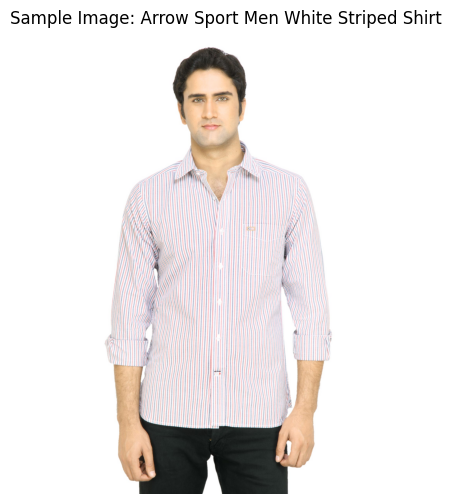

In [5]:
#Cell 5: Load a Sample Image from Cleaned Data and Display
from PIL import Image
import matplotlib.pyplot as plt
import os # Ensure os is imported

# Assuming df_cleaned is available from Cell 4, and images_dir from Cell 2

if not df_cleaned.empty:
    # Select a random item from the cleaned DataFrame
    sample_item = df_cleaned.sample(1).iloc[0]
    image_file = sample_item['image_path']

    # Load the image
    try:
        image = Image.open(image_file).convert("RGB") # Ensure it's RGB
        print(f"\nSelected image for description and feature extraction:")
        print(f"ID: {sample_item['id']}")
        print(f"Product Display Name: {sample_item['productDisplayName']}")
        print(f"Master Category: {sample_item['masterCategory']}")
        print(f"Article Type: {sample_item['articleType']}")
        print(f"Base Colour: {sample_item['baseColour']}")
        print(f"Season: {sample_item['season']}")
        print(f"Usage: {sample_item['usage']}")

        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.title(f"Sample Image: {sample_item['productDisplayName']}")
        plt.axis('off')
        plt.show()

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_file}. This should not happen if previous cleaning was perfect.")
    except Exception as e:
        print(f"An error occurred loading image {image_file}: {e}")
else:
    print("The cleaned DataFrame is empty. Cannot select a sample image.")

In [6]:
# Cell 6: Generate an image description using a Vision-Language-Model (VLM)
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch

# Load a pre-trained Vision-Language Model (VLM) for image captioning
blip_model_name = "nlpconnect/vit-gpt2-image-captioning"

try:
    # Use distinct variable names for the BLIP model components
    if 'blip_vlm_model' not in locals() or 'blip_feature_extractor' not in locals() or 'blip_tokenizer' not in locals():
        print(f"Loading VLM model: {blip_model_name}...")
        blip_vlm_model = VisionEncoderDecoderModel.from_pretrained(blip_model_name)
        blip_feature_extractor = ViTImageProcessor.from_pretrained(blip_model_name)
        blip_tokenizer = AutoTokenizer.from_pretrained(blip_model_name)
    else:
        print(f"VLM model {blip_model_name} already loaded.")
except Exception as e:
    print(f"Error loading VLM model: {e}")

# Set device to GPU if available, otherwise CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# Use the correct variable name here
blip_vlm_model.to(device)

print(f"\nUsing VLM model: {blip_model_name} on device: {device}")

# Generate caption for the loaded image
# Make sure 'image' variable is loaded from previous data loading cell (Cell 4)
if 'image' in locals():
    gen_kwargs = {"max_length": 100, "num_beams": 4} # Parameters for text generation

    pixel_values = blip_feature_extractor(images=image, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    output_ids = blip_vlm_model.generate(pixel_values, **gen_kwargs)
    raw_description = blip_tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]

    print(f"\nGenerated Raw Description:\n{raw_description}")
else:
    print("No image loaded in Cell 4. Cannot generate description.")

2025-07-23 14:22:50.739415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753280570.762489     138 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753280570.769306     138 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading VLM model: nlpconnect/vit-gpt2-image-captioning...


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to


Using VLM model: nlpconnect/vit-gpt2-image-captioning on device: cuda


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.



Generated Raw Description:
a man standing in front of a white wall 


In [7]:
# ... (rest of Cell 7 code above LLM_PROMPT_TEMPLATE) ...

# --- LLM PROMPT TEMPLATE ---
# We define the core prompt here, which instructs Gemini on how to extract attributes
# This template is what you will modify to "perfect" the extraction.
from typing import Dict, Any
LLM_PROMPT_TEMPLATE = """
    You are an expert fashion stylist AI. Your task is to analyze a clothing description and extract its key attributes into a structured JSON format. Ensure all specified fields are present. If a specific detail is not explicitly mentioned or clearly inferable from the description, use 'N/A' or 'unknown' for that field's value. Prioritize information clearly stated in the description or metadata.

    **Special instructions for inference:**
    - For 'colors', identify up to three prominent color hues present in the garment, **including colors of patterns if clearly visible (e.g., "blue" and "white" for a blue shirt with white stripes)**. Return them as a JSON array of strings. List only color names (e.g., "red", "blue", "white"), do not include pattern descriptions.
    - For 'sleeve_length', look for terms in 'productDisplayName' or infer based on 'articleType' and 'season'.
    - For 'fit', look for terms in 'productDisplayName' or implied by 'articleType'.
    - For 'material', if not explicitly mentioned, use 'unknown'. Do not guess.
    - **For 'weather_suitability'**: Infer based on 'season' (e.g., 'Summer' -> 'hot', 'Winter' -> 'cold', 'Spring'/'Fall' -> 'mild').
    - **For 'dominant_style'**: Analyze the 'productDisplayName' (e.g., brand names like 'United Colors of Benetton', 'Ed Hardy', design elements like 'graphic', 'floral') and 'usage' to infer the style (e.g., 'classic', 'graphic', 'casual', 'streetwear', 'boho'). If the brand is known for a certain style, use that.
    - **For 'accessories_suitability'**: Provide practical suggestions based on 'clothing_type' and 'occasion'. For example, for a 'Tshirt', suggest 'goes well with jeans or shorts', 'pair with sneakers or sandals'. For a 'Shirt', suggest 'can be paired with trousers or chinos'. If it's an accessory itself (like 'shoes', 'bags'), use 'N/A' or 'no specific accessories needed'.

    Here is the clothing description:
    "{vlm_description}"

    Here is additional metadata from the product for context (use this to fill missing fields or refine existing ones, prioritize based on explicit mention in description. Only use this if it helps fill a gap or provides a more specific detail for an attribute. Ensure consistency.):
    {metadata_json}

    Extract the following attributes into a JSON object. Ensure the output is *only* the JSON object, nothing else.

    {{
      "colors": "array of strings (e.g., ['red', 'blue', 'white'], ['black'], ['multi-color']) - list all prominent color hues, including pattern colors.",
      "clothing_type": "string (e.g., shirt, pants, dress, jacket, shoes, skirt, shorts, sweater, etc.)",
      "material": "string (e.g., cotton, denim, silk, wool, leather, polyester, linen, blend)",
      "pattern": "string (e.g., solid, striped, floral, plaid, checkered, polka dot, graphic, abstract)",
      "neckline": "string (e.g., crew neck, V-neck, collar, scoop neck, boat neck, turtleneck, halter)",
      "sleeve_length": "string (e.g., short, long, sleeveless, 3/4 sleeve, cap sleeve)",
      "fit": "string (e.g., slim, regular, baggy, oversized, relaxed, tailored, flared)",
      "occasion": "string (e.g., casual, formal, semi-formal, party, workout, business, loungewear)",
      "season": "string (e.g., spring, summer, autumn, winter, all-season)",
      "weather_suitability": "string (e.g., hot, cold, mild, rainy, sunny, windy)",
      "dominant_style": "string (e.g., boho, classic, trendy, minimalist, streetwear, vintage, athletic, preppy)",
      "accessories_suitability": "array of strings (e.g., 'goes well with a belt', 'suitable for a scarf', 'pair with statement necklace', 'needs no accessories')"
    }}
"""
# ... (rest of Cell 7 code below LLM_PROMPT_TEMPLATE) ...

# Helper function to call the LLM and parse the output (this uses the real Gemini)
def extract_features_with_llm(vlm_description: str, metadata: Dict[str, Any]) -> Dict[str, Any]:
    """
    Calls the Gemini LLM to extract structured features from a VLM description and metadata.
    """
    if LLM_MODEL is None:
        print("LLM model is not initialized. Cannot extract features.")
        return {}

    # Convert metadata dictionary to JSON string for the prompt
    # Remove internal attributes not relevant to the LLM's understanding of the product
    metadata_copy = metadata.copy()
    metadata_copy.pop('id', None) # 'id' is internal, not a product attribute for LLM
    metadata_copy.pop('image_path', None)
    metadata_copy.pop('image_exists', None) # Assuming this was added during cleaning
    metadata_copy.pop('expected_filename', None) # If temporary column was added
    
    metadata_json = json.dumps(metadata_copy, indent=2)

    # Format the prompt with the VLM description and metadata
    prompt = LLM_PROMPT_TEMPLATE.format(vlm_description=vlm_description, metadata_json=metadata_json)
    
    print("\n--- LLM Prompt (Sent to Gemini) ---")
    print(prompt)
    print("-" * 50)

    try:
        # Call the Gemini LLM
        response = LLM_MODEL.generate_content(prompt)
        raw_output = response.text.strip()
        
        print("\n--- Raw LLM Output (from Gemini) ---")
        print(raw_output)
        print("-" * 50)

        # Attempt to parse the JSON output from the raw text
        start_index = raw_output.find('{')
        end_index = raw_output.rfind('}') + 1
        
        if start_index != -1 and end_index != 0:
            json_string = raw_output[start_index:end_index]
            
            # Clean up the JSON string if the model added markdown code block delimiters
            if json_string.startswith("```json"):
                json_string = json_string[7:].strip()
            if json_string.endswith("```"):
                json_string = json_string[:-3].strip()

            features = json.loads(json_string)
            print("\n--- Extracted Features (Parsed JSON Output) ---")
            print(json.dumps(features, indent=2))
            print("-" * 50)
            return features
        else:
            print("Error: Could not find valid JSON output in LLM response.")
            # If JSON parsing fails, return the raw output for debugging
            return {"parsing_error": "Could not parse JSON", "raw_llm_output": raw_output}

    except Exception as e:
        print(f"Error during LLM feature extraction: {e}")
        return {"error": str(e)}

# Trying with google gemini API



In [8]:
# ==============================================================================
# SECTION 2: API Key and LLM Model Configuration (Gemini)
# ==============================================================================

import google.generativeai as genai
import os # To access environment variables
from kaggle_secrets import UserSecretsClient # Required for UserSecretsClient

# --- IMPORTANT: Access your API Key from Kaggle Secrets ---
# Based on your previous output, your secret is named "gcp_api_key".
try:
    user_secrets = UserSecretsClient()
    # Retrieve your secret named "gcp_api_key"
    # And assign it to GEMINI_API_KEY for consistency with the rest of the code
    GEMINI_API_KEY = user_secrets.get_secret("gcp_api_key")
except Exception as e:
    print(f"Could not retrieve API key from Kaggle Secrets using UserSecretsClient: {e}")
    # Fallback to os.getenv if UserSecretsClient fails (less common for secrets set in Kaggle)
    GEMINI_API_KEY = os.getenv("GEMINI_API_KEY") # This would be if your secret was named GEMINI_API_KEY directly

# --- DEBUG PRINT: Check if API Key is retrieved ---
print(f"DEBUG: Value of GEMINI_API_KEY after retrieval: {'(not set)' if GEMINI_API_KEY is None else '*****'}")
# --- END DEBUG PRINT ---


if not GEMINI_API_KEY:
    print("WARNING: GEMINI_API_KEY not found. Please set it up in Kaggle Secrets.")
    print("Exiting as API Key is mandatory for LLM calls.")
    exit() # This will stop the notebook execution if the key is missing

genai.configure(api_key=GEMINI_API_KEY)

# --- DEBUG PRINT: Confirm genai.configure() was called ---
print("DEBUG: genai.configure() called.")
# --- END DEBUG PRINT ---

# --- CRUCIAL LINE: Define the LLM_MODEL with a working model name ---
# Based on your previous output, 'models/gemini-1.5-pro' is available to you.
LLM_MODEL = genai.GenerativeModel('models/gemini-1.5-pro')

# --- DEBUG PRINT: Confirm LLM_MODEL object is created ---
print(f"DEBUG: LLM_MODEL object created: {LLM_MODEL is not None}")
# --- END DEBUG PRINT ---

print("Gemini LLM model initialized.")

DEBUG: Value of GEMINI_API_KEY after retrieval: *****
DEBUG: genai.configure() called.
DEBUG: LLM_MODEL object created: True
Gemini LLM model initialized.


In [9]:
#Cell 8.5
# Temporary Cell to List Available Gemini Models
import google.generativeai as genai

# Ensure your API key is configured. If you've run Cell 8 successfully, it should be.
# If not, add: genai.configure(api_key="YOUR_API_KEY") here for this test,
# but it's better if Cell 8 ran first.

print("Available Gemini models:")
for m in genai.list_models():
    if 'generateContent' in m.supported_generation_methods:
        print(m.name)

Available Gemini models:
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-05-20
models/gemini-2.5-flash
models/gemini-2.5-flash-lite-preview-06-17
models/gemini-2.5-pro-preview-05-06
models/gemini-2.5-pro-preview-06-05
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-preview-image-generation
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinki

In [10]:
# CELL 9: Process Sample Dataset Item with Real LLM
# This cell assumes Cell 5 (sample image load), Cell 6 (VLM description),
# and Cell 7 (LLM Setup with extract_features_with_llm function) have been run.

import json
import pandas as pd # Ensure pandas is imported for pd.notna
# The LLM_MODEL and extract_features_with_llm function are expected to be available from Cell 7.
# The raw_description and sample_item are expected to be available from Cell 6 and Cell 5 respectively.


# Define target_attributes here, ensuring it matches the prompt's schema (especially 'colors')
# Note: 'colors' is an array of strings.
target_attributes_schema = {
    "colors": "array of strings (e.g., ['red', 'blue', 'white'], ['black'], ['multi-color']) - list all prominent color hues, including pattern colors.",
    "clothing_type": "string (e.g., shirt, pants, dress, jacket, shoes, skirt, shorts, sweater, etc.)",
    "material": "string (e.g., cotton, denim, silk, wool, leather, polyester, linen, blend)",
    "pattern": "string (e.g., solid, striped, floral, plaid, checkered, polka dot, graphic, abstract)",
    "neckline": "string (e.g., crew neck, V-neck, collar, scoop neck, boat neck, turtleneck, halter)",
    "sleeve_length": "string (e.g., short, long, sleeveless, 3/4 sleeve, cap sleeve)",
    "fit": "string (e.g., slim, regular, baggy, oversized, relaxed, tailored, flared)",
    "occasion": "string (e.g., casual, formal, semi-formal, party, workout, business, loungewear)",
    "season": "string (e.g., spring, summer, autumn, winter, all-season)",
    "weather_suitability": "string (e.g., hot, cold, mild, rainy, sunny, windy)",
    "dominant_style": "string (e.g., boho, classic, trendy, minimalist, streetwear, vintage, athletic, preppy)",
    "accessories_suitability": "array of strings (e.g., 'goes well with a belt', 'suitable for a scarf', 'pair with statement necklace', 'needs no accessories')"
}


if 'raw_description' in locals() and 'sample_item' in locals() and 'extract_features_with_llm' in locals():
    print("\n--- Starting LLM Feature Extraction for Sample Dataset Item ---")
    
    # We call the function defined in Cell 7, passing the VLM description and item metadata
    extracted_features_real_llm = extract_features_with_llm(raw_description, sample_item.to_dict())
    
    if extracted_features_real_llm:
        print("\nFeature extraction complete for sample item.")
    else:
        print("\nFeature extraction failed for sample item.")

else:
    print("Cannot perform feature extraction: raw_description, sample_item, or extract_features_with_llm function not available.")
    print("Please ensure Cell 5, Cell 6, and Cell 7 have been run successfully.")


--- Starting LLM Feature Extraction for Sample Dataset Item ---

--- LLM Prompt (Sent to Gemini) ---

    You are an expert fashion stylist AI. Your task is to analyze a clothing description and extract its key attributes into a structured JSON format. Ensure all specified fields are present. If a specific detail is not explicitly mentioned or clearly inferable from the description, use 'N/A' or 'unknown' for that field's value. Prioritize information clearly stated in the description or metadata.

    **Special instructions for inference:**
    - For 'colors', identify up to three prominent color hues present in the garment, **including colors of patterns if clearly visible (e.g., "blue" and "white" for a blue shirt with white stripes)**. Return them as a JSON array of strings. List only color names (e.g., "red", "blue", "white"), do not include pattern descriptions.
    - For 'sleeve_length', look for terms in 'productDisplayName' or infer based on 'articleType' and 'season'.
    - 

Targeting item with ID: 12497 from df_cleaned for iteration.

Retrieved metadata for ID 12497:
- gender: Men
- masterCategory: Apparel
- subCategory: Topwear
- articleType: Tshirts
- baseColour: White
- season: Fall
- usage: Casual
- productDisplayName: United Colors of Benetton Men Short White Tshirts
Image path: /kaggle/input/fashion-product-images-dataset/fashion-dataset/images/12497.jpg


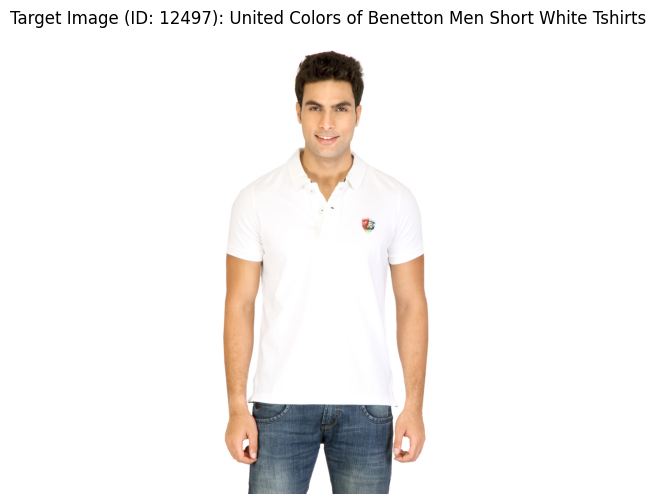


--- Generating VLM Description for Target Image ---
Generated Raw Description for Target Image:
a man standing in front of a white wall 

--- Starting LLM Feature Extraction for Target Image ---

--- LLM Prompt (Sent to Gemini) ---

    You are an expert fashion stylist AI. Your task is to analyze a clothing description and extract its key attributes into a structured JSON format. Ensure all specified fields are present. If a specific detail is not explicitly mentioned or clearly inferable from the description, use 'N/A' or 'unknown' for that field's value. Prioritize information clearly stated in the description or metadata.

    **Special instructions for inference:**
    - For 'colors', identify up to three prominent color hues present in the garment, **including colors of patterns if clearly visible (e.g., "blue" and "white" for a blue shirt with white stripes)**. Return them as a JSON array of strings. List only color names (e.g., "red", "blue", "white"), do not include pattern d

In [10]:
# REVISED CELL 10: Process Specific Dataset Item for Prompt Iteration
# This cell allows you to target a specific item from df_cleaned for consistent prompt testing.

from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd # Ensure pandas is imported

# Ensure VLM_MODEL, blip_feature_extractor, blip_tokenizer (from Cell 6)
# and extract_features_with_llm (from Cell 7) are available in scope.
# Also ensure df_cleaned is available from Cell 4.


# --- 1. Specify the ID of the item you want to iterate on ---
# Choose an ID from your df_cleaned that you know has a valid image path.
# Example: The Ed Hardy T-shirt had ID 12497. The maroon shirt might be different.
item_id_for_iteration = 12497 # <--- IMPORTANT: SET YOUR DESIRED ITEM ID HERE
print(f"Targeting item with ID: {item_id_for_iteration} from df_cleaned for iteration.")


# --- 2. Retrieve item details from df_cleaned ---
if 'df_cleaned' in locals() and not df_cleaned.empty:
    specific_item = df_cleaned[df_cleaned['id'] == item_id_for_iteration]

    if not specific_item.empty:
        specific_item_data = specific_item.iloc[0]
        image_file_path = specific_item_data['image_path']
        item_metadata = specific_item_data.drop(['id', 'image_path']).to_dict() # Get all other metadata

        print(f"\nRetrieved metadata for ID {item_id_for_iteration}:")
        for key, value in item_metadata.items():
            print(f"- {key}: {value}")
        print(f"Image path: {image_file_path}")

        # --- 3. Load and Display the Image ---
        loaded_image = None
        if os.path.exists(image_file_path):
            try:
                loaded_image = Image.open(image_file_path).convert("RGB")
                
                plt.figure(figsize=(6, 6))
                plt.imshow(loaded_image)
                plt.title(f"Target Image (ID: {item_id_for_iteration}): {item_metadata.get('productDisplayName', 'N/A')}")
                plt.axis('off')
                plt.show()

            except Exception as e:
                print(f"An error occurred loading image {image_file_path}: {e}")
        else:
            print(f"Error: Image file NOT FOUND at the specified path for ID {item_id_for_iteration}: {image_file_path}")
            print("Please ensure this image path is valid or select a different item_id_for_iteration.")
            loaded_image = None # Ensure it's None if not found

    else:
        print(f"Error: Item with ID {item_id_for_iteration} not found in df_cleaned.")
        loaded_image = None # Ensure processing is skipped
else:
    print("Error: df_cleaned DataFrame is not available or is empty. Please run Cell 4 first.")
    loaded_image = None # Ensure processing is skipped


# --- 4. Generate VLM Description for the loaded image ---
raw_description_for_llm = None
if loaded_image and 'blip_feature_extractor' in locals(): # Check VLM components are loaded
    print("\n--- Generating VLM Description for Target Image ---")
    try:
        pixel_values = blip_feature_extractor(images=loaded_image, return_tensors="pt").pixel_values
        pixel_values = pixel_values.to(device) # Ensure 'device' is available from VLM setup

        gen_kwargs = {"max_length": 100, "num_beams": 4}
        output_ids = blip_vlm_model.generate(pixel_values, **gen_kwargs) # Ensure 'blip_vlm_model' is available
        raw_description_for_llm = blip_tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0] # Ensure 'blip_tokenizer' is available

        print(f"Generated Raw Description for Target Image:\n{raw_description_for_llm}")
    except Exception as e:
        print(f"Error generating VLM description: {e}")
else:
    print("Cannot generate VLM description: Image not loaded or VLM components (Cell 6) not available.")


# --- 5. Extract Features using the Real LLM ---
if raw_description_for_llm and 'extract_features_with_llm' in locals(): # Check LLM function is loaded (from Cell 7)
    print("\n--- Starting LLM Feature Extraction for Target Image ---")
    
    # Call the LLM helper function with the VLM description and item metadata
    extracted_features_target_llm = extract_features_with_llm(raw_description_for_llm, item_metadata)
    
    if extracted_features_target_llm:
        print("\nFeature extraction complete for target item.")
        # extracted_features_target_llm now holds the parsed JSON
    else:
        print("\nFeature extraction failed for target item.")
else:
    print("Cannot perform LLM feature extraction: VLM description not available or LLM function (Cell 7) not available.")

--- Starting Feature Extraction for 3 Random Dataset Items ---

===== Processing Item 1/3 (ID: 15127) =====


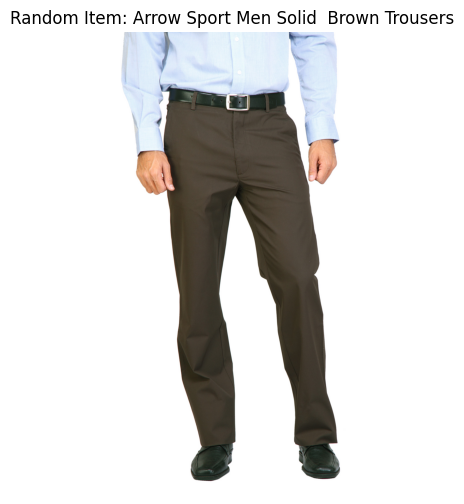


--- Generating VLM Description ---
Generated Raw Description:
a man wearing a suit and tie standing in the middle of a field 

--- Starting LLM Feature Extraction ---


NameError: name 'LLM_MODEL' is not defined

In [28]:
# CELL 11: Process Multiple Random Dataset Items
# This cell iterates through a few random items from df_cleaned to test LLM performance.

import json
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os

# Ensure df_cleaned, VLM_MODEL, blip_feature_extractor, blip_tokenizer (from Cell 6)
# and extract_features_with_llm (from Cell 7) are available in scope.

# --- Configuration ---
num_random_samples = 3 # Number of random items to process
seed = 42 # For reproducibility of random samples

print(f"--- Starting Feature Extraction for {num_random_samples} Random Dataset Items ---")

if 'df_cleaned' in locals() and not df_cleaned.empty:
    # Select random samples from df_cleaned
    random_sample_items = df_cleaned.sample(n=num_random_samples, random_state=seed)

    for i, (_, sample_item_data) in enumerate(random_sample_items.iterrows()):
        item_id = sample_item_data['id']
        image_file_path = sample_item_data['image_path']
        # Extract all other columns as metadata for the LLM
        item_metadata_dict = sample_item_data.drop(['id', 'image_path']).to_dict()

        print(f"\n===== Processing Item {i+1}/{num_random_samples} (ID: {item_id}) =====")
        
        # --- 1. Load and Display the Image ---
        loaded_image = None
        if os.path.exists(image_file_path):
            try:
                loaded_image = Image.open(image_file_path).convert("RGB")
                
                plt.figure(figsize=(6, 6))
                plt.imshow(loaded_image)
                plt.title(f"Random Item: {item_metadata_dict.get('productDisplayName', 'N/A')}")
                plt.axis('off')
                plt.show()

            except Exception as e:
                print(f"An error occurred loading image {image_file_path}: {e}")
                loaded_image = None
        else:
            print(f"Error: Image file NOT FOUND at {image_file_path}. Skipping this item.")
            loaded_image = None

        if loaded_image:
            # --- 2. Generate VLM Description ---
            raw_description = None
            if 'blip_feature_extractor' in locals():
                print("\n--- Generating VLM Description ---")
                try:
                    pixel_values = blip_feature_extractor(images=loaded_image, return_tensors="pt").pixel_values
                    pixel_values = pixel_values.to(device)

                    gen_kwargs = {"max_length": 100, "num_beams": 4}
                    output_ids = blip_vlm_model.generate(pixel_values, **gen_kwargs)
                    raw_description = blip_tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]

                    print(f"Generated Raw Description:\n{raw_description}")
                except Exception as e:
                    print(f"Error generating VLM description: {e}")
            else:
                print("VLM components not found. Skipping VLM description.")

            # --- 3. Extract Features using the Real LLM ---
            if raw_description and 'extract_features_with_llm' in locals():
                print("\n--- Starting LLM Feature Extraction ---")
                
                # Call the LLM helper function
                extracted_features = extract_features_with_llm(raw_description, item_metadata_dict)
                
                if extracted_features:
                    print(f"\nFeature extraction complete for ID {item_id}.")
                else:
                    print(f"\nFeature extraction failed for ID {item_id}.")
            else:
                print("Cannot perform LLM feature extraction: VLM description not available or LLM function not available.")
        print("\n" + "="*50) # Separator
else:
    print("Error: df_cleaned DataFrame is not available or is empty. Please run Cell 4 first.")

--- Starting Final Check on User-Provided Images ---

===== Processing Test Image 1/1 =====
Image Path: /kaggle/input/testingimages/shirt.jpg


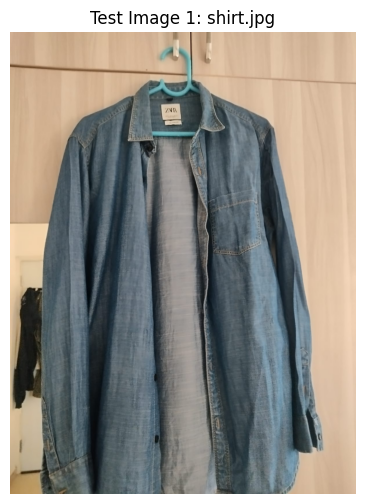

  VLM components not found. Skipping VLM description.

--- Using Dummy Metadata for LLM Context ---
{
  "gender": "unknown",
  "masterCategory": "Apparel",
  "subCategory": "unknown",
  "articleType": "unknown",
  "baseColour": "unknown",
  "season": "unknown",
  "usage": "unknown",
  "productDisplayName": "User Test Image 1 (shirt.jpg)"
}
  Cannot perform LLM feature extraction: VLM description not available or LLM function not available.


--- Final Check Complete ---


In [1]:
# CELL 13: Final Check on User-Provided Images

import json
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd # Just in case it's needed, though not directly for dataframes here

# Ensure VLM_MODEL, blip_feature_extractor, blip_tokenizer (from Cell 6)
# and extract_features_with_llm (from Cell 7) are available in scope.
# Also ensure 'device' variable is defined (e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# --- List of image paths to test ---
test_image_paths = [
    "/kaggle/input/testingimages/shirt.jpg",
]

print("--- Starting Final Check on User-Provided Images ---")

for i, image_path in enumerate(test_image_paths):
    print(f"\n===== Processing Test Image {i+1}/{len(test_image_paths)} =====")
    print(f"Image Path: {image_path}")

    # --- 1. Load and Display the Image ---
    loaded_image = None
    if os.path.exists(image_path):
        try:
            loaded_image = Image.open(image_path).convert("RGB")

            plt.figure(figsize=(6, 6))
            plt.imshow(loaded_image)
            plt.title(f"Test Image {i+1}: {os.path.basename(image_path)}")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"  Error loading image {image_path}: {e}")
            loaded_image = None
    else:
        print(f"  Error: Image file NOT FOUND at {image_path}. Skipping VLM/LLM for this image.")
        loaded_image = None

    if loaded_image:
        # --- 2. Generate VLM Description ---
        raw_description = None
        if 'blip_feature_extractor' in locals():
            print("\n--- Generating VLM Description ---")
            try:
                pixel_values = blip_feature_extractor(images=loaded_image, return_tensors="pt").pixel_values
                pixel_values = pixel_values.to(device)
                gen_kwargs = {"max_length": 100, "num_beams": 4}
                output_ids = blip_vlm_model.generate(pixel_values, **gen_kwargs)
                raw_description = blip_tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]

                print(f"Generated Raw Description:\n{raw_description}")
            except Exception as e:
                print(f"  Error generating VLM description for {image_path}: {e}")
        else:
            print("  VLM components not found. Skipping VLM description.")

        # --- 3. Prepare Dummy Metadata ---
        # IMPORTANT: Without actual metadata, many fields will be 'unknown' or less accurate.
        # The LLM relies heavily on `productDisplayName`, `baseColour`, `articleType`, etc.
        item_metadata_dict = {
            "gender": "unknown", # default to unknown
            "masterCategory": "Apparel", # common assumption for these test images
            "subCategory": "unknown",
            "articleType": "unknown",
            "baseColour": "unknown",
            "season": "unknown",
            "usage": "unknown",
            "productDisplayName": f"User Test Image {i+1} ({os.path.basename(image_path)})" # generic display name
        }
        print("\n--- Using Dummy Metadata for LLM Context ---")
        print(json.dumps(item_metadata_dict, indent=2))

        # --- 4. Extract Features using the LLM ---
        if raw_description and 'extract_features_with_llm' in locals():
            print("\n--- Starting LLM Feature Extraction ---")
            try:
                extracted_features = extract_features_with_llm(raw_description, item_metadata_dict)

                if extracted_features:
                    print("\n--- Extracted Features (Parsed JSON Output) ---")
                    print(json.dumps(extracted_features, indent=2))
                    print(f"\nFeature extraction complete for {os.path.basename(image_path)}.")
                else:
                    print(f"\nFeature extraction failed for {os.path.basename(image_path)}.")
            except Exception as e:
                print(f"  Error during LLM feature extraction for {image_path}: {e}")
        else:
            print("  Cannot perform LLM feature extraction: VLM description not available or LLM function not available.")
    print("\n" + "="*50) # Separator

print("\n--- Final Check Complete ---")

In [17]:
# THIS IS MY CODE IT WORKS GOOD THIS IS LIKE THE BEST ONE OUT THERE THATS ACTUALLY WORKING SO DONT MESS THIS UP DONT EVEN TOUCH THIS

import json
import pandas as pd
import google.generativeai as genai
import os

# Ensure target_attributes is defined - UPDATED FOR MULTIPLE COLORS & CLARITY
target_attributes = {
    "colors": "array of strings (e.g., ['red', 'blue', 'white'], ['black'], ['multi-color']) - list all prominent color hues, avoiding pattern names.",
    "clothing_type": "string (e.g., shirt, pants, dress, jacket, shoes, skirt, shorts, sweater, etc.)",
    "material": "string (e.g., cotton, denim, silk, wool, leather, polyester, linen, blend)",
    "pattern": "string (e.g., solid, striped, floral, plaid, checkered, polka dot, graphic, abstract)",
    "neckline": "string (e.g., crew neck, V-neck, collar, scoop neck, boat neck, turtleneck, halter)",
    "sleeve_length": "string (e.g., short, long, sleeveless, 3/4 sleeve, cap sleeve)",
    "fit": "string (e.g., slim, regular, baggy, oversized, relaxed, tailored, flared)",
    "occasion": "string (e.g., casual, formal, semi-formal, party, workout, business, loungewear)",
    "season": "string (e.g., spring, summer, autumn, winter, all-season)",
    "weather_suitability": "string (e.g., hot, cold, mild, rainy, sunny, windy)",
    "dominant_style": "string (e.g., boho, classic, trendy, minimalist, streetwear, vintage, athletic, preppy)",
    "accessories_suitability": "array of strings (e.g., 'goes well with a belt', 'suitable for a scarf', 'pair with statement necklace', 'needs no accessories')"
}

# --- Ensure API key configuration from Cell 8 is run first ---
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("gcp_api_key")
    genai.configure(api_key=api_key) # Re-configure in case session reset
except Exception as e:
    api_key = os.getenv("GEMINI_API_KEY") # Fallback
    if api_key:
        genai.configure(api_key=api_key)
    else:
        print("API Key not found. Please set it up in Kaggle Secrets or as an environment variable.")
        raise SystemExit("API Key is essential for this cell to run.")


if 'raw_description' in locals() and 'sample_item' in locals() and api_key:
    try:
        model = genai.GenerativeModel('gemini-1.5-flash')

        # --- UPDATED PROMPT HERE FOR MULTIPLE COLORS & AVOIDING PATTERN DUPLICATION ---
        llm_prompt = f"""
        You are an expert fashion stylist AI. Your task is to analyze a clothing description and extract its key attributes into a structured JSON format. Ensure all specified fields are present. If a specific detail is not explicitly mentioned or clearly inferable from the description, use 'N/A' or 'unknown' for that field's value. Prioritize information clearly stated in the description or metadata.

        **Special instructions for inference:**
        - For 'colors', identify up to three most prominent color hues in the garment (primary, secondary, and tertiary if present). Return them as a JSON array of strings. **Crucially, list only color names (e.g., "red", "blue", "white"), do not include pattern descriptions (e.g., do NOT include "striped", "floral" here).** If only one color is prominent, return it as `["color_name"]`. If no color is mentioned or clearly inferable, use `["unknown"]`.
        - For 'sleeve_length', consider 'clothing_type' (e.g., "Tshirts" often implies short sleeve, "Jacket" implies long sleeve) and 'productDisplayName' (e.g., "Polo" often implies short sleeve).
        - For 'fit', look for terms in 'productDisplayName' or implied by 'articleType' (e.g., "Skinny Jeans" implies 'slim', "Oversized Sweatshirt" implies 'baggy').
        - For 'material', if not explicitly mentioned, use 'unknown'. Do not guess.

        Here is the clothing description:
        "{raw_description}"

        Here is additional metadata from the product for context (use this to fill missing fields or refine existing ones, prioritize based on explicit mention in description. Only use this if it helps fill a gap or provides a more specific detail for an attribute. Ensure consistency.):
        {json.dumps({k: v for k, v in sample_item.to_dict().items() if k not in ['id', 'image_path']}, indent=2)}

        Extract the following attributes into a JSON object. Ensure the output is *only* the JSON object, nothing else.

        {json.dumps(target_attributes, indent=2)}
        """

        print("\n--- LLM Prompt (Sent to Gemini) ---")
        print(llm_prompt)
        print("------------------------------------\n")

        response = model.generate_content(
            llm_prompt,
            generation_config=genai.types.GenerationConfig(
                temperature=0.1,
            ),
            safety_settings=[
                {"category": "HARM_CATEGORY_HARASSMENT", "threshold": "BLOCK_NONE"},
                {"category": "HARM_CATEGORY_HATE_SPEECH", "threshold": "BLOCK_NONE"},
                {"category": "HARM_CATEGORY_SEXUALLY_EXPLICIT", "threshold": "BLOCK_NONE"},
                {"category": "HARM_CATEGORY_DANGEROUS_CONTENT", "threshold": "BLOCK_NONE"},
            ]
        )

        raw_llm_output = response.text.strip()
        print("\n--- Raw LLM Output (from Gemini) ---")
        print(raw_llm_output)
        print("-------------------------------------\n")

        # Remove markdown code block fences if present
        if raw_llm_output.startswith("```json") and raw_llm_output.endswith("```"):
            json_string = raw_llm_output[len("```json"): -len("```")].strip()
        else:
            json_string = raw_llm_output.strip()

        try:
            extracted_features_real_llm = json.loads(json_string)
            print("\n--- Extracted Features (Parsed from Real LLM Output) ---")
            print(json.dumps(extracted_features_real_llm, indent=2))
            print("----------------------------------------------------------")
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON from LLM response: {e}")
            print("Attempted to parse this string:")
            print(json_string)
            print("Raw LLM output (before stripping markdown):")
            print(raw_llm_output)

    except Exception as e:
        print(f"An error occurred during the LLM API call: {e}")
        print("Please check your API key, internet connection, and API limits.")
else:
    if not api_key:
        print("API Key not available. Please ensure it's configured in Cell 8.")
    else:
        print("Raw description or sample_item not available. Please run cells 5 and 6 first.")


--- LLM Prompt (Sent to Gemini) ---

        You are an expert fashion stylist AI. Your task is to analyze a clothing description and extract its key attributes into a structured JSON format. Ensure all specified fields are present. If a specific detail is not explicitly mentioned or clearly inferable from the description, use 'N/A' or 'unknown' for that field's value. Prioritize information clearly stated in the description or metadata.

        **Special instructions for inference:**
        - For 'colors', identify up to three most prominent color hues in the garment (primary, secondary, and tertiary if present). Return them as a JSON array of strings. **Crucially, list only color names (e.g., "red", "blue", "white"), do not include pattern descriptions (e.g., do NOT include "striped", "floral" here).** If only one color is prominent, return it as `["color_name"]`. If no color is mentioned or clearly inferable, use `["unknown"]`.
        - For 'sleeve_length', consider 'clothing_ty